# Binarization

## 1. Prerequisites

### 1. Download dataset example

Download the image dataset [here](https://gforge.inria.fr/frs/download.php/file/35148/data_set_0962_A310_ARCH2013-05-13.zip) and extract it. After this, indicate the path in **data_path_directory** variable below. 

In [1]:
data_path_directory = "./data_set_0962_A310_ARCH2013-05-13/"

### 1.2. Load  files paths

In [2]:
import glob
import os

images_path = glob.glob(data_path_directory + '*.png')

files_path = dict()
for image_path in images_path:
    
    file_name = os.path.basename(image_path)
    date = file_name.split(' ')[0].split('_')[-1]
    if date not in files_path:
        files_path[date] = dict()
        
    if 'sv' in image_path:
        angle = file_name.split('_sv')[1].split('.png')[0]
        files_path[date][int(angle)] = image_path
    elif 'tv' in image_path:
        angle = -1
        files_path[date][int(angle)] = image_path
        
        
print "Number pot : 0962"
print "Genotype Id : A310"
print "Dates : ", files_path.keys()

Number pot : 0962
Genotype Id : A310
Dates :  ['2013-05-24', '2013-06-22', '2013-06-06', '2013-06-25']


### 1.3. Load Images

Here, we load all the image of the dataset to simply the toturial, commodly you load just the images you want process one after the other.

In [3]:
import cv2

images_dataset = dict()
for date in files_path:
    images_dataset[date] = dict()
    for angle in files_path[date]:
        images_dataset[date][angle] = cv2.imread(files_path[date][angle], flags=cv2.IMREAD_COLOR)

### 1.3. Display images 

You can view each image according to this date and angle of view like this :
Note : Angle top view is represented by negative number (-1)

<IPython.core.display.Javascript object>


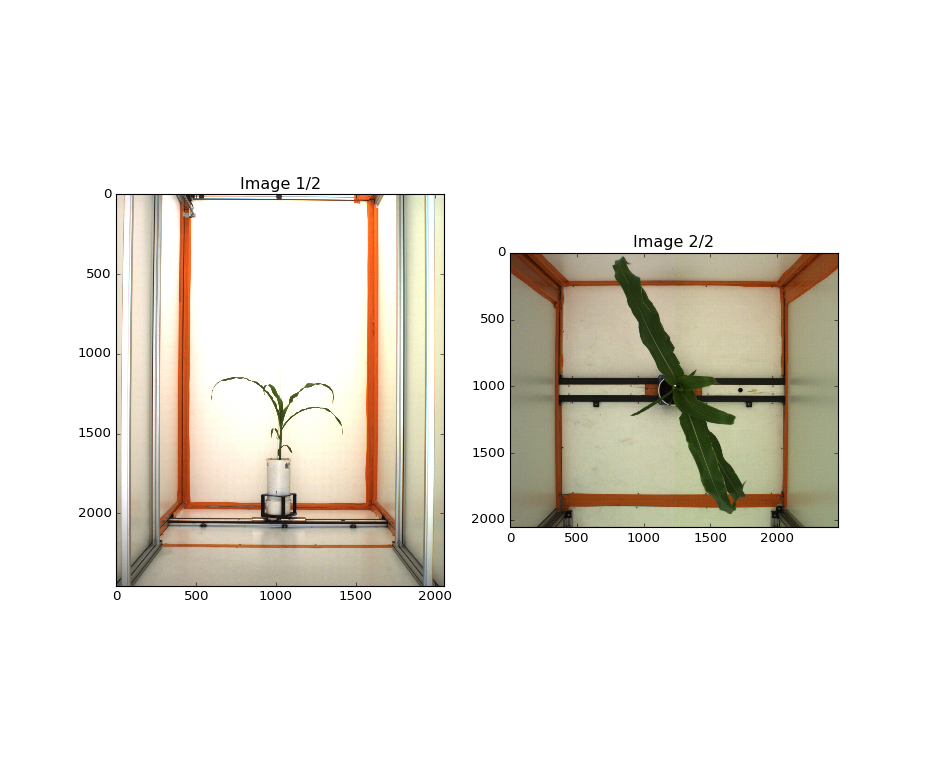

In [10]:
%matplotlib notebook

from alinea.phenomenal.display.image import show_images

show_images([images_dataset['2013-06-06'][120], images_dataset['2013-06-22'][-1]])

## 2. Binarization

### 2.1. Define a binarization routines

In [23]:
from alinea.phenomenal.data_access.plant_1 import(
    plant_1_mask_mean_shift, 
    plant_1_mask_hsv, 
    plant_1_mask_clean_noise)

from alinea.phenomenal.binarization import (
    erode_dilate, 
    dilate_erode,
    close,
    meanshift,
    hsv)

def routine_side_binarization(image, mean_image):

    cv2.imwrite("image_src.png", image)
    cv2.imwrite("mean_image.png", mean_image)
    
    threshold = 0.3
    dark_background = False

    hsv_min = (30, 11, 0)
    hsv_max = (129, 254, 141)
    mask_mean_shift = plant_1_mask_mean_shift()
    mask_hsv = plant_1_mask_hsv()
    mask_clean_noise = plant_1_mask_clean_noise()
    
    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Threshold the image with HSV min and max value
    binary_hsv_image = hsv(hsv_image, hsv_min, hsv_max, mask_hsv)

    # Produce Image figure
    cv2.imwrite("mask_hsv.png", mask_hsv)
    cv2.imwrite("binary_hsv_image.png", binary_hsv_image)
    
    # Threshold the image with difference between image and mean_image
    binary_mean_shift_image = meanshift(
        image, mean_image, threshold, dark_background, mask_mean_shift)
    cv2.imwrite("binary_mean_shift_image.png", binary_mean_shift_image * 255)
    cv2.imwrite("mask_mean_shift.png", mask_mean_shift)
    
    # Add the two image
    result = cv2.add(binary_hsv_image, binary_mean_shift_image * 255)

    # Erode and dilate the image to remove possible noise
    result = erode_dilate(result, iterations=3, mask=mask_clean_noise)
    result = erode_dilate(result, iterations=1)

    cv2.imwrite("mask_clean_noise.png", mask_clean_noise)
    cv2.imwrite("image_dst.png", result)
    
    return result


def routine_top_binarization(image):
    hsv_min = (42, 75, 28)
    hsv_max = (80, 250, 134)
    median_blur_size=9
    iterations=5
    
    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Apply a median blur on the image
    hsv_image = cv2.medianBlur(hsv_image, ksize=median_blur_size)

    # Threshold the image with HSV min and max value
    bin_img = hsv(hsv_image, hsv_min, hsv_max)
    # dilate and erode the image to remove possible noise
    bin_img = dilate_erode(bin_img, kernel_shape=(3, 3),iterations=iterations)

    return bin_img

### 2.2. Binarize images

In [24]:
from alinea.phenomenal.binarization.routines import mean

# Select image at 2013/06/06
images = images_dataset['2013-06-22']

# Select the side image
side_images = [images[angle] for angle in range(0, 360, 30)]
# Compute the mean image of the side view image
mean_image = mean(side_images)

# Binarize all the images with the routine appropriate 
images_binarize = dict()
# angles = range(0, 360, 30)
angles = [120]

for angle in angles:
    image = images[angle]
    
    if angle < 0:
        images_binarize[angle]= routine_top_binarization(image)
    else:
        images_binarize[angle] = routine_side_binarization(image, mean_image)

In [13]:
cv2.imwrite("image_binarize_120.png", images_binarize[120])

True

In [ ]:
images_dataset.keys()

### 2.3. Display images binarize 

In [ ]:
%matplotlib notebook

show_images([images_dataset['2013-06-06'][120], images_binarize[120], mean_image])

### 2.4 Plant area estimation

In [ ]:
import numpy

def plant_area(pixel_counts, a=3.261011e-06, b=0.04240879):
    """
    Plant area estimation from pixels counts
    """
    pix = numpy.array(pixel_counts)
    return a * pix + b

pixel_count = 0
for angle in range(0, 360, 30):
    pixel_count += cv2.countNonZero(images_binarize[angle])
    
pixel_count /= len(range(0, 360, 30))
area = plant_area(pixel_count)
print "Plant area estimation with mean number of pixel :", area